# Control of a Fabry Perot Michelson Interferometer

This notebook sets up a MIMO control loop to control the DARM, CARM, and BS degrees of freedom of an FPMI.

[__1.__](#overview) A detailed description of the control loop topology is given first. It is not necessary to understand this in detail before working through the example, but a general familiarity with the diagram will be useful.

[__2.__](#suspension) Next, a simple model of a triple suspension is made, with little explanation, since only the result is needed for this example.

[__3.__](#om-plant) Then the optomechanical plant is computed with Finesse. The purpose of this notebook is to explain the control system, so this model is built in a separate file.

[__4.__](#control-system) Then the control system is defined.

[__5.__](#loop-tfs) Some open and closed loop transfer functions are computed.

[__6.__](#darm-nb) A simple DARM noise budget is made with the seismic noise from the optics and the sensing noise from all three degrees of freedom.

[__7.__](#residual) Finally, the residual in-loop motion of the optics is computed.

The OptickleControlFPMI notebook goes through the identical calculations with Optickle. (Section [3](#om-plant) is the only part that has any differences.)

In [1]:
import numpy as np
import pytickle.finesse as fin
import pytickle.controls as ctrl
import pytickle.noise as pytnoise
import scipy.signal as sig
from pytickle.plotting import plotTF
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

                                              ..-
    PyKat 1.2.1           _                  '(
                          \`.|\.__...-""""-_." )
       ..+-----.._        /  ' `            .-'
   . '            `:      7/* _/._\    \   (
  (        '::;;+;;:      `-"' =" /,`"" `) /
  L.        \`:::a:f            c_/     n_'
  ..`--...___`.  .    ,
   `^-....____:   +.      www.gwoptics.org/pykat



In [2]:
mpl.rc('figure', figsize=(8, 11))

mpl.rcParams.update({'text.usetex': False,
                     'mathtext.fontset': 'cm',
                     'lines.linewidth': 3,
                     'lines.markersize': 10,
                     'font.size': 16,
                     'axes.grid': True,
                     'grid.alpha': 0.5,
                     'legend.loc': 'best',
                     'savefig.dpi': 80,
                     'pdf.compression': 9})

In [3]:
import katFPMI
import parFPMI

<a name="overview"> </a>

## Control System Overview

*__Note: the PyTickle convention is that control signals are directly summed into the error point without an explicit minus sign.__ Closed-loop transfer functions are thus $(\mathbb{1} - G)^{-1}$, loops go unstable when open-loop transfer functions $G$ are +1, and the Nyquist criteria requires the Nyquist contour to circle the point +1 clockwise the same number of times as there are right half plane poles in $G$.*

Here is a detailed overview of the architecture of the control systems. The topology of a general MIMO system is shown below. It may help to come back to some details after working through parts of the example.

<img src="../../documentation/control_loop.svg">
Note that if the drive is a pitch or yaw, the units should be taken as $\mathrm{m}\to\mathrm{rad}$ and $\mathrm{N}\to\mathrm{N}\cdot\mathrm{m}$.

<p>&nbsp;</p>

* Signal types. There are three types of signals. The type of signal propagating along each link in the diagram above is shown in red. The units of each signal are also marked.
    * Drives: These are the inputs to a model, for example mirror motion (longitudinal, pitch, or yaw) or laser frequency modulation.
    * Probes: These are the photodiodes that sense the power at various ports of the model, for example `REFL_I`, `AS_Q`, etc.
    * Degrees of Freedom (DOFs): These are the degrees of freedom relevant to the model, for example DARM, CARM, MICH, PRCL, and SRCL for the longitudinal DOFs in a dual-recycled Fabry Perot Michelson interferometer.
    
<p>&nbsp;</p>
    
* The blocks have the following meanings:
    * The optomechanical plant $P_\mathrm{om}$ is the AC transfer function from drives to probes and is what Finesse calculates with `kat.getTF(probe, drive)`. Conceptually it can be broken down into a radiation pressure "loop suppression function" $R$ which modifies the mechanical response of mirrors and an optical plant $P_\mathrm{opt}$ which only includes the optical response. See below for details.

    * The input matrix $I$ defines which probes are used to sense each DOF.

    * The control filters $C$ define the feedback and feedforward dynamics of the loop.
    
    * The output matrix $O$ defines which combinations of drives make up each DOF.

    * The actuation function $A$ is the transfer function from the point that the control loop actuates on each drive to the motion of that drive. In the example of a multi-stage suspension used for a test mass mirror, the position of the mirror may be actuated on by applying a force on the stage above rather than on the mirror itself. The function $A$ is then the mechanical plant from forces on this stage to test mass motion.
    
    * The compensation filters $K$ invert the actuation plants with the goal to make $AK\approx \mathbb{1}$. (In practice the entire block $KOCI$ can be thought of as the (possibly digital) controller, but it is more convenient to break this up as shown in the diagram above.)

<p>&nbsp;</p>

* Test points. These are the points along the loop where signals can be probed or injected and are marked as arrows going into or out of the loop.
    * The difference between the $x_\mathrm{drive}$ and $x_\mathrm{pos}$ test points is described in detail below, but can be understood simply as follows. The effects of radiation pressure can be thought of as a feedback loop. The block $R$ is the closed loop transfer function of this radiation pressure loop, $x_\mathrm{drive}$ is the input signal to the loop, and $x_\mathrm{pos}$ is the output signal from the loop.
    * The name used in PyTickle to refer to each test point is the same as the subscript in the figure. So, for example, to compute the transfer function from $d_\mathrm{err}$ to $x_\mathrm{pos}$, you'd use `cs.getTF(sig_to, pos, sig_from, err)`
    * The test point `spot` is not shown in the diagram but exists for angular DOFs to convert the test point `drive` into beamspot motion on an optic.
    * With the exception of `pos` (which only probes a signal) and `cal` (which only injects a signal), all test points can both probe and inject signals.


### Detailed description of the optomechanical plant and related test points

The following may be skipped at first but is included to give a complete understanding of the optomechanical plant and of the difference between the $x_\mathrm{pos}$, $x_\mathrm{drive}$, and $d_\mathrm{act}$ test points.

<p>&nbsp;</p>

Consider a model with $n_\mathrm{f}$ optical field components described by the vector $E=[E_1, \dots, E_{n_\mathrm{f}}]^T$ and $n_\mathrm{d}$ drives described by the vector $x=[x_1, \dots, x_{n_\mathrm{d}}]^T$. The job of Finesse is to find $E$ and $x$ for a given excitation $E_\mathrm{exc}$ and $x_\mathrm{exc}$. They are related by

$$ \begin{bmatrix}
E\\
x
\end{bmatrix}
=
\begin{bmatrix}
G_{\mathrm{ff}} & G_{\mathrm{fd}}\\
G_{\mathrm{df}} & G_{\mathrm{dd}}
\end{bmatrix}
\begin{bmatrix}
E\\
x
\end{bmatrix}
+
\begin{bmatrix}
E_\mathrm{exc}\\
x_\mathrm{exc}
\end{bmatrix}.
$$
When we build a model by adding optics, drives, and links, we define the response of fields to other fields $G_\mathrm{ff}$ and to drives $G_\mathrm{fd}$. Setting mechanical transfer functions with `setMechTF(kat, 'optic', z, p, k)` completes the definition of the radiation pressure induced response of drives to fields $G_\mathrm{df}$ and to other drives $G_\mathrm{dd}$. The solution to the above equation, which is found by calling `katFR.run(fmin, fmax, npts)`, is
$$\begin{bmatrix}
E\\
x
\end{bmatrix}
=
\left(\mathbb{1} - G\right)^{-1} \begin{bmatrix}
E_\mathrm{exc}\\
x_\mathrm{exc}
\end{bmatrix}
$$

<p>&nbsp;</p>

To separate the optical response from radiation pressure effects, first consider just the fields. *In the absence of drives and just considering excitations of the fields themselves*, i.e. $G$ is just the upper left block $G_{\mathrm{ff}}$, the solution is
$$E = \left(\mathbb{1} - G_\mathrm{ff}\right)^{-1} E_\mathrm{exc} \equiv H_\mathrm{ff} E_\mathrm{exc}.$$
However, we do not measure or excite fields directly. Instead it is the power on photodiodes that is measured, and there is some matrix $S$ that converts the fields in the model to the power measured at the photdiodes. The fields are excited by modulating drives, whether that is driving an amplitude or phase modulator or modulating the position of a mirror. We can thus write the excitation as $E_\mathrm{exc} = G_\mathrm{fd} x_\mathrm{pos}$ where $x_\mathrm{pos}$ is the modulation leading to this excitation. Then the optical plant is the optical response taking into account the physical production and measurement of excitations:
$$ P_\mathrm{opt} = S H_\mathrm{ff} G_\mathrm{fd}.$$
The important point is that $P_\mathrm{opt}$ only includes the dynamics of the fields themselves. Writing $E_\mathrm{exc} = G_\mathrm{fd} x_\mathrm{pos}$ just describes how the field excitations could be generated by modulating drives. PyTickle does not currently calculate $P_\mathrm{opt}$ separately because Finesse does not compute it directly and it is not straightforward to extract.

<p>&nbsp;</p>

Radiation pressure is itself a feedback loop with open loop transfer function $G_\mathrm{dd} + G_\mathrm{df}H_\mathrm{ff}G_\mathrm{fd}$. The drives are therefore related to each other through the radiation pressure loop suppression function
$$x = \left(\mathbb{1} - G_\mathrm{dd} - G_\mathrm{df}H_\mathrm{ff}G_\mathrm{fd}\right)^{-1} x_\mathrm{exc}
\equiv R x_\mathrm{exc}.$$
Calling `katFR.getMechMod(drive_out, drive_in)` computes $R$. The optomechanical plant includes the radiation pressure modification to the drives
$$P_\mathrm{om} = P_\mathrm{opt} R.$$
Calling `katFR.getTF(probes, drives)` calculates $P_\mathrm{om}$. As an example, in a detuned cavity $P_\mathrm{opt}$ includes the optical resonance but not the up-shifted mechanical resonance from the optical spring. The latter effect is described by $R$.

<p>&nbsp;</p>

The meaning of the test points is then the following
  * $x_\mathrm{pos}$: the actual location or angle of a mirror.
  * $d_\mathrm{act}$: the force used to actuate on the mirror. If the mirror is suspended from a multi-stage pendulum and actuated on from the stage above it, $A$ is the mirror response to forces acting on the stage above it. If the actuation is to the mirror itself and the mirror can be treated as a free mass, $A=1/m s^2$.
  * $x_\mathrm{drive}$: the position of the mirror if it were not part of an optical system and thus not subject to radiation pressure feedback. In the example of a free mass with a force $F$ applied directly to it $x_\mathrm{pos} = -F/m\omega^2$. In general, $x_\mathrm{pos} = AF$. If the mass is suspended from a multistage suspension and the displacement noise of the suspension point, in $\mathrm{m}/\mathrm{Hz}^{1/2}$, is known to be $S_\mathrm{sp}^{1/2}$, this noise should be injected into the loop at $x_\mathrm{drive}$. If $T$ is the transfer function from suspension point displacement to mirror displacement, the displacement noise of the mirror in an optical system is then $S_\mathrm{mirr}^{1/2} = \left| RT \right| S_\mathrm{sp}^{1/2}$.
  
<p>&nbsp;</p>

*__Note: the above description of the optomechanical plant is conceptually correct but is not how the calculations are done internally.__ So do not try to calculate $P_\mathrm{opt}$ as $P_\mathrm{om}R^{-1}$.*

<a name="suspension"> </a>

## Suspensions (Optional Step)

You'll usually get the suspension, or other actuation, model (if used at all) from somewhere else. You can just run the cells in this section and continue.

For the sake of this example, we'll make a simple model of a triple suspension as a three mass system coupled by springs. A convenient way to find the mechanical plant for the suspensions is to use the state space representation

\begin{align}
\dot{x} &= Ax + Bu\\
y &= Cx + Du
\end{align}
where $x$ is the state vector of the system, $u$ is a vector of inputs, $y$ is the observation vector, and $A$ encodes the equations of motion.

In [4]:
def define_filt(zpk):
    """Define a PyTickle Filter from a scipy.signal zpk object
    """
    return ctrl.Filter(zpk.zeros, zpk.poles, zpk.gain, Hz=False)

In [5]:
# rough starting guesses for resonances and Q's
w1 = 2*np.pi*0.1
w2 = 2*np.pi*0.1
w3 = 2*np.pi*1
Q1 = 100
Q2 = 100
Q3 = 100
m1 = 600
m2 = 400
m3 = 100

k1 = w1**2 * m1
k2 = w2**2 * m2
k3 = w3**2 * m3

KK = np.array([[-(k1 + k2)/m1, k2/m1, 0],
               [k2/m2, -(k2 + k3)/m2, k3/m2],
               [0, k3/m3, -k3/m3]])

A = np.block([[np.zeros((3, 3)), np.eye(3)],
               [KK, np.diag([-w1/Q1, -w2/Q2, -w3/Q3])]])

B_tst = np.zeros((6, 1))
B_pum = np.zeros((6, 1))
B_sus = np.zeros((6, 1))
C_tst = np.zeros((1, 6))
B_tst[5, 0] = 1/m3   # force on test mass
B_pum[4, 0] = 1/m2   # force on PUM
B_sus[3, 0] = k1/m1  # suspension point motion
C_tst[0, 2] = 1      # observe test mass motion
D = np.array([[0]])

In [6]:
# compute state space representation
ss_tst = sig.StateSpace(A, B_tst, C_tst, D)
ss_pum = sig.StateSpace(A, B_pum, C_tst, D)
ss_sus = sig.StateSpace(A, B_sus, C_tst, D)

# convert to zpk
zpk_tst = ss_tst.to_zpk()
zpk_pum = ss_pum.to_zpk()
zpk_sus = ss_sus.to_zpk()

# convert to PyTickle Filters
tst2tst = define_filt(zpk_tst)  # test mass force to position
pum2tst = define_filt(zpk_pum)  # PUM force to test mass position
sus2tst = define_filt(zpk_sus)  # sus point position to test mass position

/home/kevin/anaconda3/envs/finesse/lib/python3.7/site-packages/scipy/signal/filter_design.py:1619: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  "results may be meaningless", BadCoefficients)


In [7]:
ff2 = np.logspace(-2, 2, 500)

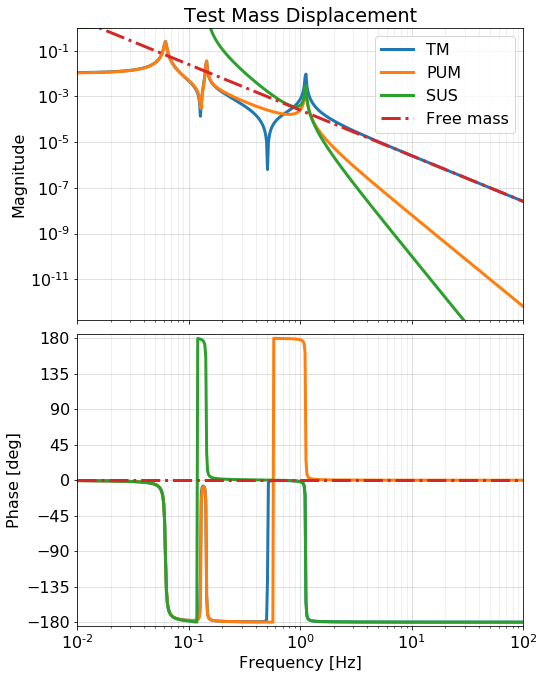

In [8]:
fig = tst2tst.plotFilter(ff2, label='TM');
pum2tst.plotFilter(ff2, fig.axes[0], fig.axes[1], label='PUM')
sus2tst.plotFilter(ff2, fig.axes[0], fig.axes[1], label='SUS')
plotTF(ff2, 1/(m3*(2*np.pi*ff2)**2), fig.axes[0], fig.axes[1], ls='-.', label='Free mass')
fig.axes[0].legend();
fig.axes[0].set_title('Test Mass Displacement');

<a name="om-plant"> </a>

## Compute the optomechanical plant

The function `katFPMI` creates a Finesse model of a Fabry Perot Michelson interferometer using the parameters specified by the function `parFPMI` which takes as arguments the mechanical plants for the optics. The mechanical transfer functions of all the optics are set using
```python
fin.setMechTF(kat, 'optic', z, p, z)
```
commands in this function. Since this is the mechanical transfer function from forces on the test mass (where radiation pressure acts) to position on the test mass, we should use the `zpk_tst` part of the suspension model, which falls like $1/f^2$ above the suspension resonances, here.

Note that the `kat` model used in a PyTickle control system simulation does not have to be created in PyTickle and can, for example, be generated by PyKat by parsing classic Finesse code. It is also possible to compute the optomechanical plant once, save it, and load it back for future use as is explained in the basic Fabry Perot example. The steps in the following three cells would then be unnecessary.

In [9]:
par = parFPMI.parFPMI(zpk_tst.zeros, zpk_tst.poles, zpk_tst.gain)

kat = katFPMI.katFPMI(par)

By default, the response of a Finesse model to all drives is computed. With complex models this can take some time. The computation time can be reduced if only a subset of the drives will be needed for further computations by
```python
katFR = fin.KatFR(kat, all_drives=False)
katFR.addDrives(drive_list)  # add with a list
katFR.addDrives('EX')        # or add additional drives one at a time
```

Even if the Finesse `kat` model was created outside of PyTickle, a PyTickle `KatFR` frequency response model must be generated from it.

In [10]:
# We are only going to use the ETM's and the beamsplitter below
katFR = fin.KatFR(kat, all_drives=False)
katFR.addDrives(['EX', 'EY', 'BS'])

In [11]:
# Run the model
fmin = 0.3
fmax = 1e3
npts = 400
katFR.run(fmin, fmax, npts)

100%|██████████| 3/3 [00:00<00:00,  5.32it/s]


In [12]:
ff = katFR.ff  # get the frequency vector used to calculate the frequency response

In [13]:
# Define the probes that will be used to sense each DOF. See more below.
DARM = dict(EX=1/2, EY=-1/2)
CARM = dict(EX=1/2, EY=1/2)

probesDARM = {'AS_Q': 1/np.abs(katFR.getTF('AS_Q', DARM)[0])}
probesCARM = {'REFL_I': 1/np.abs(katFR.getTF('REFL_I', CARM)[0])}
probesBS   = {'REFL_Q': 1/np.abs(katFR.getTF('REFL_Q', 'BS')[0])}

<a name="control-system"> </a>

## Define control system

### Control filters

The first step in defining a control system is to specify the filters. These filters can be defined in three ways:

1. Giving a standard zpk definition
```python
filt = ctrl.Filter(z, p, k)
```
where `z` and `p` are arrays with the zeros and poles and `k` is a scalar specifying the gain.
2. Giving a zpk definition but specifying the gain at a specific frequency. To set the gain to be `k0` at frequency `f0` use
```python
filt = ctrl.Filter(z, p, k0, f0)
```
3. Giving a callable function that is the s-domain filter
```python
filt = ctrl.Filter(func)
```

<p>&nbsp;</p>

By default the zeros and poles are real frequencies specified in Hz. Using `Hz=False` specifies the frequencies in the s-domain instead. For example, all of the following specify the same single pole low-pass filter with 1 Hz corner frequency
```python
ctrl.Filter([], 1, 1)
ctrl.Filter([], -2*np.pi, 1, Hz=False)
ctrl.Filter(lambda s: 1/(s + 2*np.pi))
```

<p>&nbsp;</p>

There are a few convenience functions for defining filters
* The function `resRoots(f0, Q)` computes the two conjugate roots of a resonance specified by a resonance frequency `f0` and quality factor `Q`
$$r_\pm = \frac{f_0}{2Q}\left(1 \pm \sqrt{1 - 4Q^2}\right)$$
As with the filter definitions, `resRoots` returns the roots as real frequencies in Hz by default but will instead give s-domain frequencies using `Hz=False`.
* Multiple filters can be combined into a single filter with `catfilt`. For example
```python
filt = ctrl.catfilt(filt1, filt2, filt3)
```
* Lists of zeros and poles can be combined with `catzp`. For example, a pole at 1 Hz and a complex pair of poles corresponding to a 50 Hz resonance with a Q of 100 can be defined with
```python
poles = ctrl.catzp(1, ctrl.resRoots(50, 10))
```

In [14]:
# define the DOF filters
filtDARM = ctrl.Filter(ctrl.catzp(ctrl.resRoots(2, 1), ctrl.resRoots(5, 1)),
                       ctrl.catzp(0, 0, 0, ctrl.resRoots(0.5, 1), ctrl.resRoots(110, 1)),
                       -1, 20)

filtCARM = filtDARM

filtBS   = ctrl.Filter(ctrl.catzp(ctrl.resRoots(1, 1), ctrl.resRoots(3, 1)),
                       ctrl.catzp(0, 0, 0, ctrl.resRoots(0.3, 1), ctrl.resRoots(90, 1)),
                       -1, 15)

# simple constant feedforward filter
filtFF   = ctrl.Filter([], [], -4.98e-3)
# filtFF   = ctrl.Filter([], [], 0)

A simple constant gain filter has been defined for feedforward subtraction of BS motion to DARM. Without the feedforward subtraction of beamsplitter motion, the sensing noise from `REFL_Q` used to sense BS would limit the DARM sensitivity until about 100 Hz. Set the feedforward gain to zero and rerun the cells below to see the effects of the feedforward.

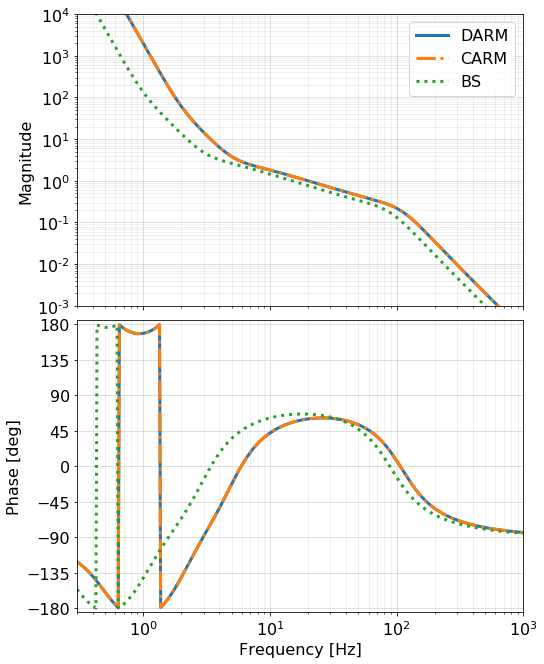

In [15]:
# plot the filters
fig = filtDARM.plotFilter(ff, label='DARM')
filtCARM.plotFilter(ff, fig.axes[0], fig.axes[1], ls='-.', label='CARM')
filtBS.plotFilter(ff, fig.axes[0], fig.axes[1], ls=':', label='BS')
fig.axes[0].legend();
fig.axes[0].set_ylim(1e-3, 1e4);

### Degrees of freedom

The next step is to define the degrees of freedom and the filters between them. Start a new control system with
```python
cs = ctrl.ControlSystem()
```
and then add degrees of freedom with
```python
cs.addDOF(dof_name, probes, drives, drive_type)
```
where `dof_name` is the name of the DOF, `probes` are the probes used to sense it and `drives` are the drives that define it. Both `probes` and `drives` can be strings or dictionaries, just as in `opt.getTF(probes, drives)`. `drive_type` specifies whether the drive is longitudinal motion, pitch, yaw, etc. By default, `drive_type` is longitudinal motion. (This defines both the input $I$ and output $O$ matrices in the diagram above.)

<p>&nbsp;</p>

Next add the control filters between the DOFs with
```python
cs.addFilter(dof_to, dof_from, filt)
```
(This defines the control block $C$ in the diagram above.) Note that to feedforward the control signal from `dof1` to `dof2`, you should concatenate the `dof1` control filter `filt1` with the feedforward filter `filt_ff` (otherwise it would be the `dof1` error signal being fedforward):
```python
cs.addFilter(dof2, dof1, ctrl.catfilt(filt_ff, filt1))
```

<p>&nbsp;</p>

Finally specify which Finesse model to use for the optomechanical plant ($P_\mathrm{om}$ in the diagram above)
```python
cs.setOptomechanicalPlant(katFR)
```
Note that `katFR` should have already been run.

In [16]:
# Define control system
cs = ctrl.ControlSystem()

# define degrees of freedom
cs.addDOF('DARM', probesDARM, DARM)
cs.addDOF('CARM', probesCARM, CARM)
cs.addDOF('BS', probesBS, 'BS')

# define control filters
cs.addFilter('DARM', 'DARM', filtDARM)
cs.addFilter('CARM', 'CARM', filtCARM)
cs.addFilter('BS', 'BS', filtBS)

# add the feedforward
cs.addFilter('DARM', 'BS', ctrl.catfilt(filtFF, filtBS))

# set the optomechanical plant
cs.setOptomechanicalPlant(katFR)

In practice, even if only a single probe is used to sense a given DOF, it is useful to define it as a one element dictionary and divide by the DC response (as we've done here) so that $d_\mathrm{err} \sim x_\mathrm{cal}$ at DC. In this example, we would have had instead $d_\mathrm{err}\sim 10^{10}\, x_\mathrm{cal}$ if we had used `AS_Q` instead of `probesDARM` (and would have had to appropriately scale the filter gains by this ammount).

<p>&nbsp;</p>

Finally note that uncontrolled degrees of freedom an be added simply by adding them with `addDOF` but not adding any control filters for them. Since these degrees of freedom do not need to be sensed, they can be defined with empty `probe` dictionaries as well.

### Actuation and compensation (Optional)

The final step is to add actuators and compensation filters. Since the goal is to make $AK\approx\mathbb{1}$, this step is optional. If nothing is defined, PyTickle will assume that $AK = \mathbb{1}$.

Actuators and compensation filters should also be `Filter` objects. Set the actuators and compensatation filters for each drive with
```python
cs.setActuator(drive, drive_type, act_filt)
cs.addCompensator(drive, drive_type, comp_filt)
```

This control system is going to actuate on test mass position by applying forces on the PUM, the stage above the test mass, rather than directly on the test mass itself. We should thus use the `pum2tst` part of the suspension model, which falls like $1/f^4$ above the suspension resonances, here.

In [17]:
# Use low Q resonances to partially compensate for the suspension plants
gainf0 = 1/np.abs(pum2tst.computeFilter(10))
pum2tst_comp = ctrl.Filter(
    ctrl.catzp(ctrl.resRoots(63e-3, 10), ctrl.resRoots(0.145, 10), ctrl.resRoots(1.12, 15)),
    ctrl.resRoots(0.13, 10),
    gainf0, 10)
mechTF = ctrl.catfilt(pum2tst, pum2tst_comp)  # total transfer function from ctrl to drive

In [18]:
ff2 = np.logspace(-2, 1, 500)

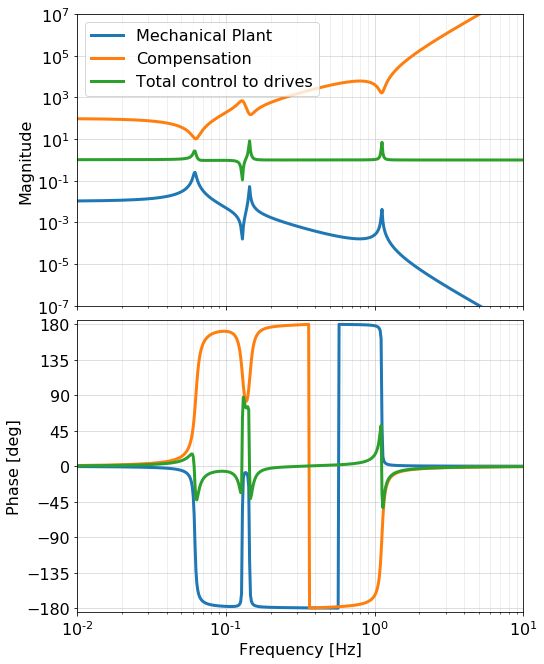

In [19]:
# plot the results
fig = pum2tst.plotFilter(ff2, label='Mechanical Plant');
pum2tst_comp.plotFilter(ff2, fig.axes[0], fig.axes[1], label='Compensation');
mechTF.plotFilter(ff2, fig.axes[0], fig.axes[1], label='Total control to drives');
fig.axes[0].legend();
fig.axes[0].set_ylim(1e-7, 1e7);

In [20]:
# in more complicted models, the different drives could have different filters
for drive in ['EX', 'EY', 'BS']:
    cs.setActuator(drive, 'pos', pum2tst)
    cs.addCompensator(drive, 'pos', pum2tst_comp)

<a name="loop-tfs"> </a>

## Run the simulation

In [21]:
cs.run()

In [22]:
# compute stability margins for the loops
cs.print_margins('err')

,UGF,phase margin,max sensitivity,stability margin
DARM,19.96 Hz,57.14 deg,73.09 Hz,0.73
CARM,19.96 Hz,57.14 deg,73.09 Hz,0.73
BS,15.03 Hz,65.56 deg,67.40 Hz,0.78


## Compute some loop transfer functions

Transfer functions from any signal `sig_fr` at one test point `tst_fr` to any other signal `sig_to` at another test point `tst_to` can be calculated either closed loop with
```python
cs.getTF(sig_to, tst_to, sig_fr, tst_fr)
```
or open loop with
```python
cs.getTF(sig_to, tst_to, sig_fr, tst_fr, closed=False)
```

The full matrix can be returned by leaving the signals blank:
```python
cs.getTF('', tst_to, '', tst_fr)
```

#### Open loop transfer functions

Open loop transfer functions from `sig_fr` to `sig_to` breaking the loop at the `tstpnt` test point are computed with
```python
cs.getOLTF(sig_to, sig_fr, tstpnt)
```

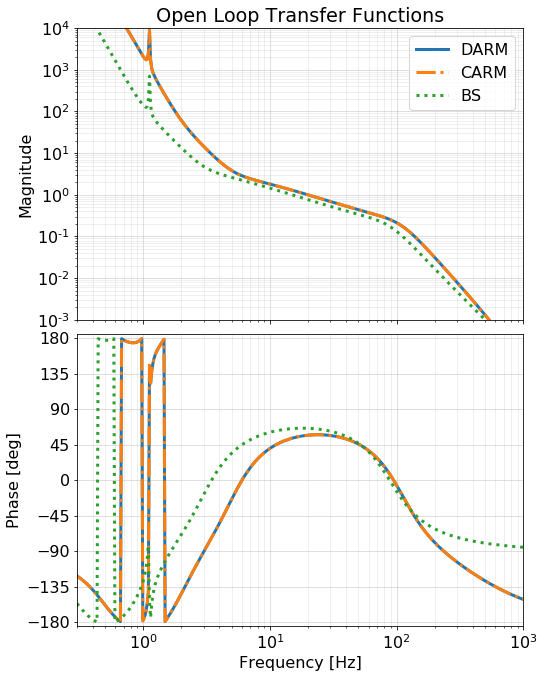

In [23]:
fig = plotTF(ff, cs.getOLTF('DARM', 'DARM', 'err'), label='DARM')
plotTF(ff, cs.getOLTF('CARM', 'CARM', 'err'), fig.axes[0], fig.axes[1], ls='-.', label='CARM')
plotTF(ff, cs.getOLTF('BS', 'BS', 'err'), fig.axes[0], fig.axes[1], ls=':', label='BS')
fig.axes[0].legend()
fig.axes[0].set_title('Open Loop Transfer Functions')
fig.axes[0].set_ylim(1e-3, 1e4);

#### Closed loop transfer functions

If $G$ is an open loop transfer function, $(\mathbb{1} - G)^{-1}$ is the corresponding closed loop transfer function. Closed loop transfer functions from `sig_fr` to `sig_to` breaking the loop at the `tstpnt` test point are similarly computed with
```python
cs.getCLTF(sig_to, sig_fr, tstpnt)
```

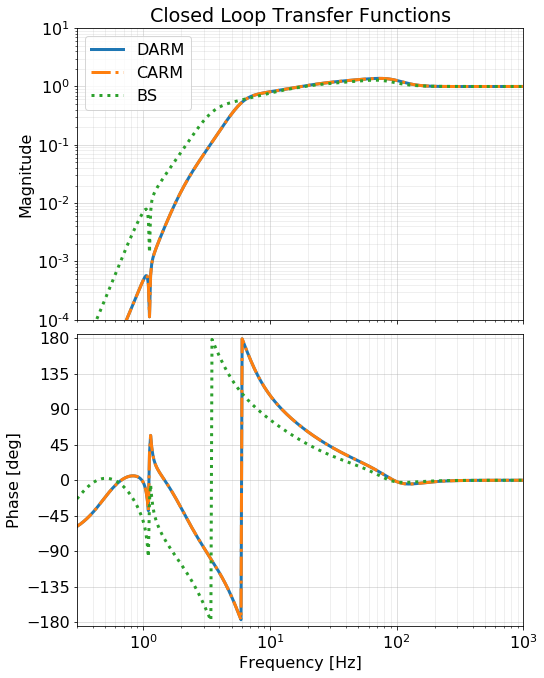

In [24]:
fig = plotTF(ff, cs.getCLTF('DARM', 'DARM', 'err'), label='DARM')
plotTF(ff, cs.getCLTF('CARM', 'CARM', 'err'), fig.axes[0], fig.axes[1], ls='-.', label='CARM')
plotTF(ff, cs.getCLTF('BS', 'BS', 'err'), fig.axes[0], fig.axes[1], ls=':', label='BS')
fig.axes[0].legend()
fig.axes[0].set_title('Closed Loop Transfer Functions')
fig.axes[0].set_ylim(1e-4, 10);

#### DOF cross couplings

Cross couplings between the degrees of freedom are calculated when `sig_to` and `sig_fr` are different. Here we plot the open-loop cross couplings from the auxiliary DOFs CARM and BS to DARM.

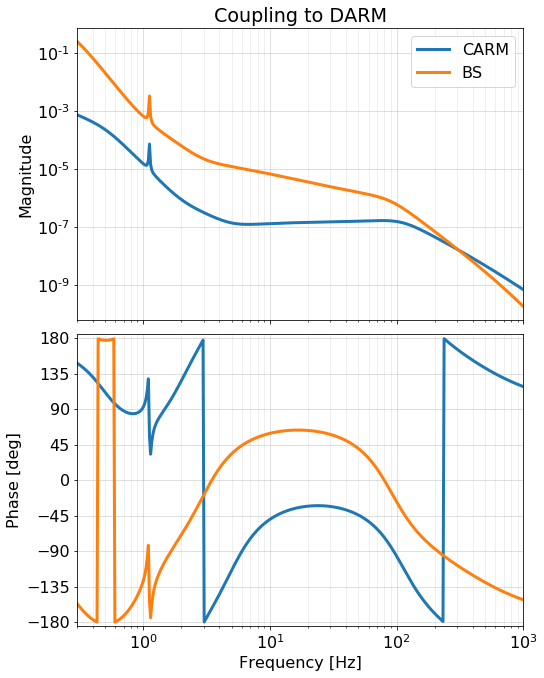

In [25]:
fig = plotTF(ff, cs.getOLTF('DARM', 'CARM', 'err'), label='CARM')
plotTF(ff, cs.getOLTF('DARM', 'BS', 'err'), fig.axes[0], fig.axes[1], label='BS')
fig.axes[0].legend()
fig.axes[0].set_title('Coupling to DARM');

#### Calibration

The calibration test point `cal` is used to see how a degree of freedom signal injected into the error point propagates throughout the loop. This is necessary, among other things, to make the usual signal referred noise budgets when considering noise sources injected at different points in the loop, as is discussed below.

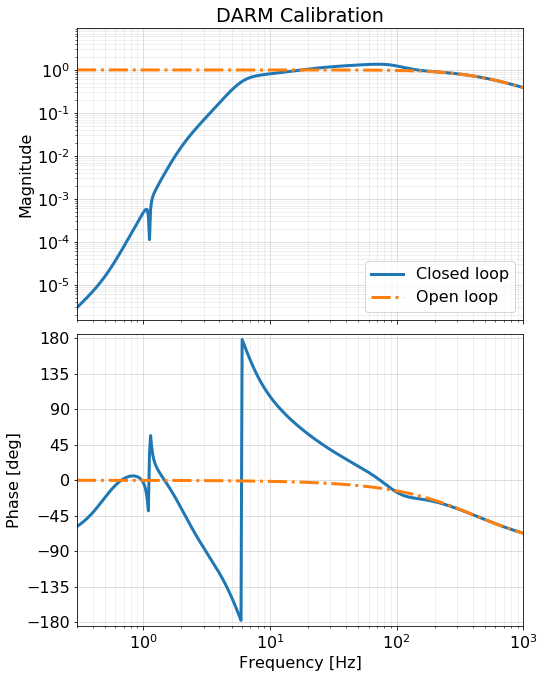

In [26]:
fig = plotTF(ff, cs.getTF('DARM', 'err', 'DARM', 'cal'), label='Closed loop')
plotTF(ff, cs.getTF('DARM', 'err', 'DARM', 'cal', closed=False), fig.axes[0], fig.axes[1], ls='-.', label='Open loop')
fig.axes[0].legend()
fig.axes[0].set_title('DARM Calibration');

<a name="darm-nb"> </a>

## Total DARM referred noise

This section calculates the total sensing and seismic noise in DARM.

#### Propagating noise through control loops

Let $S_{t_1}^{1/2}$ be the noise at test point $t_1$. If $H_{t_2, t_1}$ is the *closed loop* transfer function from $t_1$ to $t_2$, then the actual in-loop noise at $t_2$ is $|H_{t_2, t_1}| S_{t_1}^{1/2}$. We usually like to think about what the equivalent noise would be if it was due to noise in the degree of freedom itself injected at the error point, i.e. the signal referred noise. To find this, we have to divide by the closed loop transfer function $H_{t_2,t_\mathrm{cal}}$ from the calibration test point to $t_2$. The noise is then
$$S_{t_2}^{1/2} = \frac{|H_{t_2, t_1}|}{|H_{t_2, t_\mathrm{cal}}|} S_{t_1}^{1/2}.$$

<p>&nbsp;</p>

To see that this reproduces the usual procedure used when making noise budgets when not considering the effects of control loops and auxiliary degrees of freedom, consider a simple SISO loop for the single degree of freedom of interest where the open loop transfer function is just $G=P_\mathrm{om}C$. Suppose we want to measure at the error signal `err`. The closed loop calibration transfer function, with units $\mathrm{W}/\mathrm{m}$, is
$$H_{\mathrm{err}, \mathrm{cal}} = \frac{P_\mathrm{om}}{1 - G}.$$
Let $S_\mathrm{disp}^{1/2}$ be the displacement noise, in $\mathrm{m}/\mathrm{Hz}^{1/2}$, and $S_\mathrm{sens}^{1/2}$ be the sensing noise, in $\mathrm{W}/\mathrm{Hz}^{1/2}$. The actual in-loop noise in the error signal, in $\mathrm{W}/\mathrm{Hz}^{1/2},$ due to these sources is
$$\bar{S}_\mathrm{disp}^{1/2} = \frac{P_\mathrm{om}}{1 - G} S_\mathrm{disp}^{1/2}, \qquad \bar{S}_\mathrm{sens}^{1/2} = \frac{1}{1 - G} S_\mathrm{sens}^{1/2}.$$
Dividing by $H_{\mathrm{err}, \mathrm{cal}}$ then gives the equivalent *open loop* noise in the degree of freedom, in $\mathrm{m}/\mathrm{Hz}^{1/2}$,
$$\left[ S^{(\mathrm{dof})}_\mathrm{disp}\right]^{1/2} = S_\mathrm{disp}^{1/2}, \qquad \left[ S^{(\mathrm{dof})}_\mathrm{sens}\right]^{1/2} = \frac{1}{|P_\mathrm{om}|} S_\mathrm{sens}^{1/2}.$$

This is the usual thing when making noise budgets: we plot displacement noises directly and divide the quantum noise by the optomechanical plant.

In [27]:
# compute the closed loop DARM calibration
DARM_cal_closed = np.abs(cs.getTF('DARM', 'err', 'DARM', 'cal'))

#### Sensing noise (Shot noise)

Sensing noise comes from the quantum noise of the photodiodes getting imposed on the control system. This noise should thus be injected at the `sens` test point. Semiclassically this shotnoise, in $\mathrm{W}/\mathrm{Hz}^{1/2}$, is
$$S^{1/2} = \sqrt{2h\nu P}$$
where $P$ is the power on the photodiode of interest. However, this is not applicable in general and does not account for, for example, radiation pressure and squeezed light. Using
```python
katFR.getQuantumNoise(probe)
```
computes the correct quantum noise in all situations.

In [28]:
# dictionary of quantum noise for each probe in W/rtHz
shot_noise = {probe: katFR.getQuantumNoise(probe) for probe in cs.probes}

In [29]:
# compute the signal referred sensing noise
sensing_noise = {}
for probe, sn in shot_noise.items():
    # closed loop propagation from probe to error signal
    tf = np.abs(cs.getTF('DARM', 'err', probe, 'sens'))
    sensing_noise[probe] = tf * sn / DARM_cal_closed

#### Displacement noise (Seismic noise, etc.)

As described in detail above, displacement noises _at the optic_ should be injected at the `drive` test point. Actuation force noises (not considered here) should be injected at the `act` test point. Force noises at the optic should be converted to displacement noises at the optic and again injected at `drive`.

To convert seismic noise at the suspension point to displacement noise at the optics, we should use the `sus2tst` part of the suspension model, which falls like $1/f^6$ above the suspension resonances, here.

In [30]:
# filter the seismic noise through the suspensions
seismic_sus = 1e-8 / ff**2  # seismic displacement noise at the suspension point [m/rtHz]
seismic_tst = np.abs(sus2tst.computeFilter(ff)) * seismic_sus  # noise at the test mass [m/rtHz]

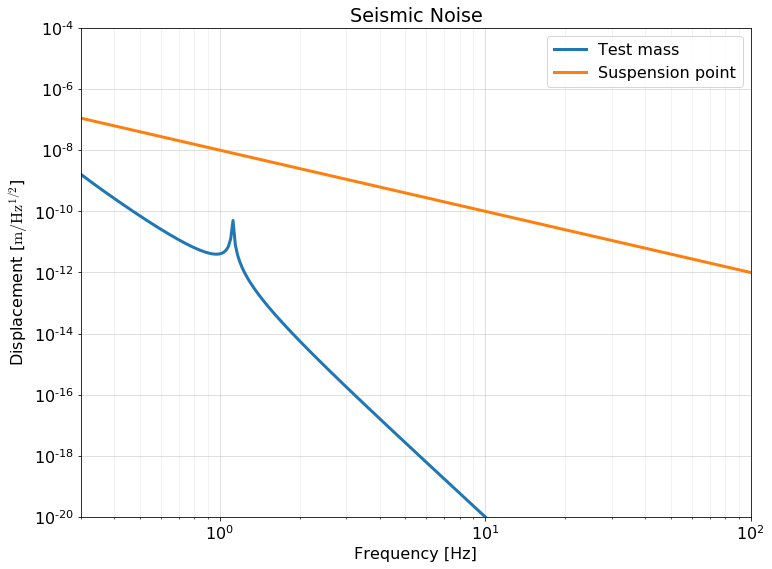

In [31]:
# plot the open-loop noise at the suspension point and at the optics
fig = plt.figure(figsize=(12, 9))
ax = fig.gca()
ax.loglog(ff, seismic_tst, label='Test mass')
ax.loglog(ff, seismic_sus, label='Suspension point')
ax.legend()
ax.legend()
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel(r'Displacement [$\mathrm{m}/\mathrm{Hz}^{1/2}$]')
ax.set_title('Seismic Noise')
# ax.set_xlim(ff[0], ff[-1])
ax.set_xlim(ff[0], 100)
ax.set_ylim(1e-20, 1e-4)
ax.grid(which='minor', alpha=0.2);

In [32]:
# Seismic noise at the test masss and beamsplitter in m/rtHz
# In more complicated models different optics might have different seismic spectra
seismic_noise = {drive: seismic_tst for drive in cs.drives}

In [33]:
# compute the signal referred displacement noise
displacement_noise = {}
for drive, sn in seismic_noise.items():
    # closed loop propagation from drive to error signal
    tf = np.abs(cs.getTF('DARM', 'err', drive, 'drive'))
    displacement_noise[drive] = tf * sn / DARM_cal_closed

#### Total noise

In [34]:
# add all the noise sources in quadrature
total_noise = np.sum([sn**2 for sn in sensing_noise.values()], axis=0)
total_noise += np.sum([dn**2 for dn in displacement_noise.values()], axis=0)
total_noise = np.sqrt(total_noise)

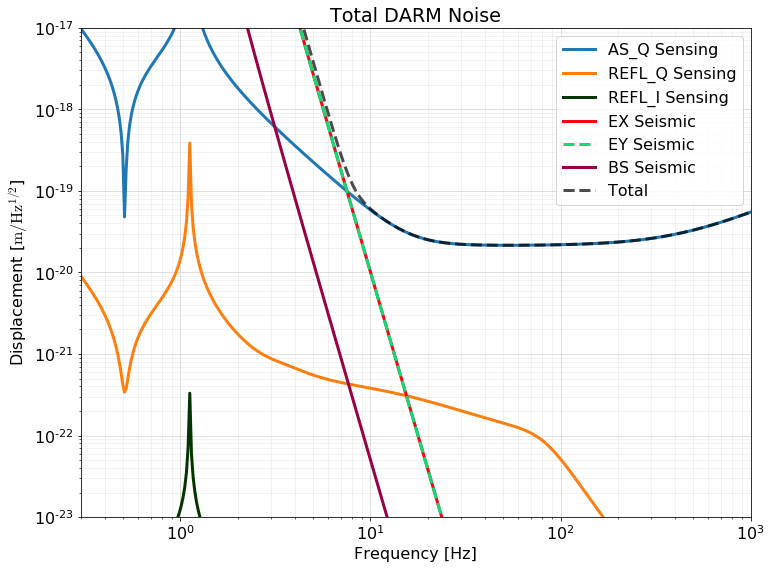

In [35]:
fig = plt.figure(figsize=(12, 9))
ax = fig.gca()
ax.loglog(ff, sensing_noise['AS_Q'], label='AS_Q Sensing')
ax.loglog(ff, sensing_noise['REFL_Q'], label='REFL_Q Sensing')
ax.loglog(ff, sensing_noise['REFL_I'], c='xkcd:dark green', label='REFL_I Sensing')
ax.loglog(ff, displacement_noise['EX.pos'], c='xkcd:bright red', label='EX Seismic')
ax.loglog(ff, displacement_noise['EY.pos'], c='xkcd:tealish green', ls='--', label='EY Seismic')
ax.loglog(ff, displacement_noise['BS.pos'], c='xkcd:purple red', label='BS Seismic')
ax.loglog(ff, total_noise, 'k--', alpha=0.7, label='Total')
ax.legend()
ax.grid(which='minor', alpha=0.2)
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel(r'Displacement [$\mathrm{m}/\mathrm{Hz}^{1/2}$]')
ax.set_title('Total DARM Noise')
ax.set_xlim(ff[0], ff[-1]);
# ax.set_xlim(0.3, 3e3)
ax.set_ylim(1e-23, 1e-17);

<a name="residual"> </a>

## Residual motion

As described in detail above, the actual motion of an optic should be probed at the `pos` test point. To compute the total residual noise due to several noise sources injected at different test points, we have to compute the closed-loop transfer function from each of these test points to `pos` and sum the contribution of each noise source in quadrature. The convenience function `getTotalNoiseTo` does this automatically. If `noiseASDs` is a dictionary of noise ASDs for several signals, specified by the keys, to be injected at test point `tst_fr`, the total noise in the signal `sig_to` at test point `tst_to` due to these noise sources is
```python
cs.getTotalNoiseTo(sig_to, tst_to, tst_fr, noiseASDs)
```
The function `computeRMS(ff, asd)` calculates the (reverse) cumulative RMS
$$\Delta x(f) = \left[\int^{f_\mathrm{max}}_f S_x(f')\;\mathrm{d}f'\right]^{1/2}$$
where $S_x^{1/2}$ is `asd` and $f_\mathrm{max}$ is the maximum frequency in the frequency vector `ff`.

In [36]:
# Residual motion due to seismic noise
residual_seismic = {drive: cs.getTotalNoiseTo(drive, 'pos', 'drive', seismic_noise)
                    for drive in cs.drives}
rms_seismic = {drive: pytnoise.computeRMS(ff, asd) for drive, asd in residual_seismic.items()}

In [37]:
# Residual motion due to sensing noise
residual_sensing = {drive: cs.getTotalNoiseTo(drive, 'pos', 'sens', shot_noise)
                    for drive in cs.drives}
rms_sensing = {drive: pytnoise.computeRMS(ff, asd) for drive, asd in residual_sensing.items()}

In [38]:
# Total residual motion
# Add the motion due to seismic noise and shot noise in quadrature
residual_total = {drive: np.sqrt(residual_seismic[drive]**2 + residual_sensing[drive]**2)
                 for drive in cs.drives}
rms_total = {drive: pytnoise.computeRMS(ff, asd) for drive, asd in residual_total.items()}

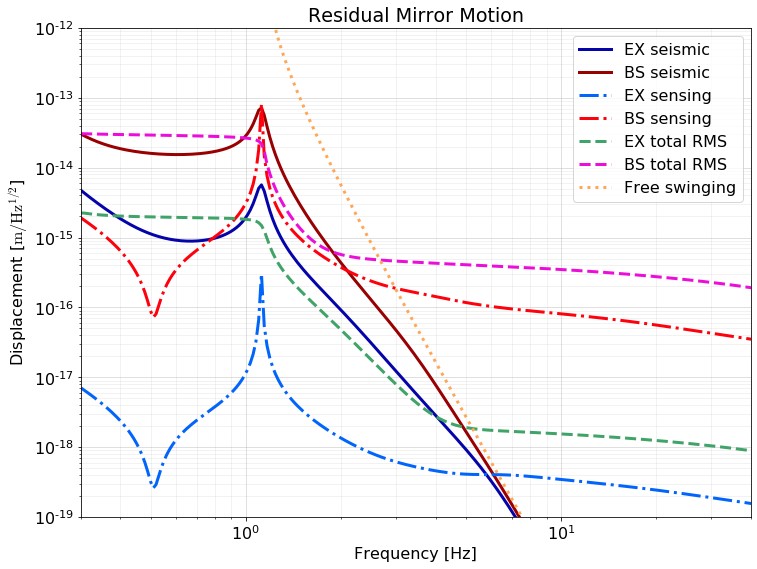

In [39]:
fig = plt.figure(figsize=(12, 9))
ax = fig.gca()
ax.loglog(ff, residual_seismic['EX.pos'], c='xkcd:royal blue', label='EX seismic')
ax.loglog(ff, residual_seismic['BS.pos'], c='xkcd:blood red', label='BS seismic')
ax.loglog(ff, residual_sensing['EX.pos'], c='xkcd:bright blue', ls='-.', label='EX sensing')
ax.loglog(ff, residual_sensing['BS.pos'], c='xkcd:bright red', ls='-.', label='BS sensing')
ax.loglog(ff, rms_total['EX.pos'], c='xkcd:greenish', ls='--', label='EX total RMS')
ax.loglog(ff, rms_total['BS.pos'], c='xkcd:fuchsia', ls='--', label='BS total RMS')
ax.loglog(ff, seismic_tst, c='xkcd:pale orange', ls=':', label='Free swinging')
ax.grid(which='minor', alpha=0.2)
ax.set_title('Residual Mirror Motion')
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel(r'Displacement [$\mathrm{m}/\mathrm{Hz}^{1/2}$]')
ax.legend()
ax.set_ylim(1e-19, 1e-12);
ax.set_xlim(0.3, 40);